# 0. Resources
- [`Admixtools`](https://github.com/DReichLab/AdmixTools)
- [`admixr`](https://github.com/bodkan/admixr)
- [`admixr`-tutorial:](https://bodkan.net/admixr/articles/tutorial.html)
- [Patterson et al. (2012)](http://www.genetics.org/content/192/3/1065)
- [Bhatia et al. (2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/)
- [Peter (2016)](http://www.genetics.org/content/202/4/1485)
- [Petr et al. (2019)](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz030/5298728)


# 1.  Setting up
To get your own copy of this tutorial, you will need to copy it to your directory by logging into the console and copying it over:

````bash
cp -r ~ben/fstats/ .

```

Next, you will need to start R remotely, and load the required packages for the tutorial

In [1]:
suppressPackageStartupMessages({
    library(admixr)
    library(data.table)
    library(tidyverse)
    source("scripts/analysis.R")
})

Let us know if any of this does not work

# 2. Data
For this tutorial, we will be using data from the (fully public) version of
 Lazaridis et al 2014, that can be downloaded from
https://reich.hms.harvard.edu/datasets. This data has an unique ascertainment
scheme, so throughout we need to keep ascertainment bias in mind. 

In order to save time, I subset the data and converted it to various formats,
namely the `plink` and `eigenstrat` formats that we will be using throughout.

In [2]:
list.files("data/europe/")
list.files("data/world/")

[1] "europe.1.frq"       "europe.1.frq.strat" "europe.1.log"      
 [4] "europe.bed"         "europe.bim"         "europe.fam"        
 [7] "europe.geno"        "europe.ind"         "europe.log"        
[10] "europe.plinklist"   "europe.pop_geo"     "europe.poplist"    
[13] "europe.snp"

[1] "world.1.frq"       "world.1.frq.strat" "world.1.log"      
 [4] "world.bed"         "world.bim"         "world.fam"        
 [7] "world.frq"         "world.frq.strat"   "world.geno"       
[10] "world.ind"         "world.log"         "world.plinklist"  
[13] "world.poplist"     "world.snp"         "world.traw"

To see which samples we have available, we can load the file containing all the individuals into `R`

In [3]:
world <- eigenstrat("data/world//world")
ind <- admixr::read_ind(world)



**Question 1:** How many individuals and populations are there in this data set?

In [4]:
table(ind$label)


 AA_Denver     French        Han    Khomani MbutiPygmy     Papuan  Sardinian 
        12         25         33         11         10         14         27 
    Sindhi      Surui      Uygur      Yakut     Yoruba 
        18          8         10         20         70 

# 4. Admixture-F3
We will use the `world`-dataset that contains a small set of samples from all
continents. We'll hypothesize that Uygurs are an admixed group resulting from the mixture of two populations. We'll try to find the pair of Han and another populations in our panel. We would like to know which one matches best. For this, we'll resort to using Admixture F3 statistics.

The standard way is to use the program `qp3pop` from `admixtools`. As you did yesterday for PCA, one has to 
1. write a par-file 
2. write a pop-file
3. run `qp3pop`
4. parse the output

We are too lazy to do that. Luckily, `admixr` allows us to do all those four steps in one go:

In [5]:
world <- admixr::eigenstrat("data/world//world")
ind <- admixr::read_ind(world)
pops <- unique(ind$label)
pops <- pops[!pops %in% c("Uygur", "Han")]

f3_res = f3(world, A=pops, B="Han", C="Uygur")

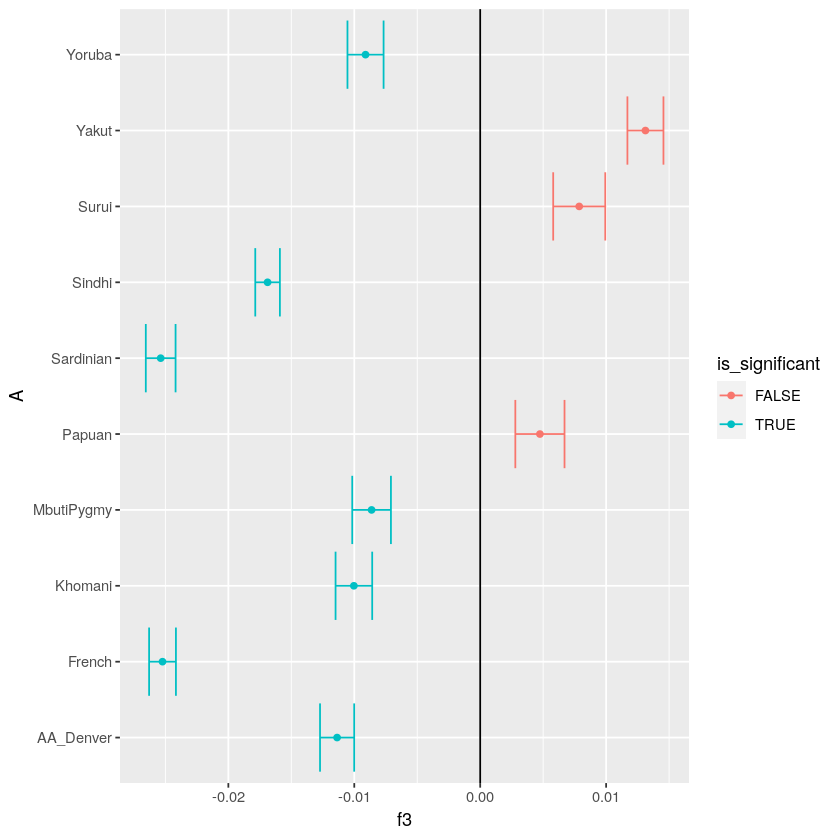

In [6]:
f3_res %>% 
    mutate(is_significant=Zscore < -3) %>%
    ggplot(aes(x=A, y=f3, ymin=f3-3*stderr, ymax = f3+3*stderr, color=is_significant)) +
    geom_point() + geom_errorbar() +geom_hline(yintercept = 0) + coord_flip()

**Question 3**: 
- Are any $F_3$-statistics negative? 
- Are they significant? (|Z| > 3?)?
- Which pairs of populations do these correspond to? 
- What could this mean about the population genetic history of the Uygurs?

# 5. Outgroup-F3
Next, we can compute outgroup-F3 stats in a very similar fashion. To do so,
we'll use the European data. 

In the data, you will find a population labelled as `unknown`. 
Which population could they be most closely related to?

We can use a very similar approach as before:
 - C will be the `Mbuti`-population
 - B will be the `unknown`-population
 - A will be the list of all candidates

**Task 2:** Use `admixr` (or if you _really_ prefer, `qp3Pop` manually) to 
1. load an eigenstrat object for the `europe`-dataset
2. read all populations present in that data into memory using the `read_ind` function
3. calculate all outgroup-$F_3$-statistics
4. create a figure visualizing your results. You may use the following function:

In [7]:
viz_outgroup_f3 <- function(f3_res){
    f3_res %>% 
    ggplot(aes(x=A, y=f3, ymin=f3-3*stderr, ymax = f3+3*stderr)) +
    geom_point() + 
    geom_errorbar() +
    geom_hline(yintercept = 0) + 
    coord_flip()
    }

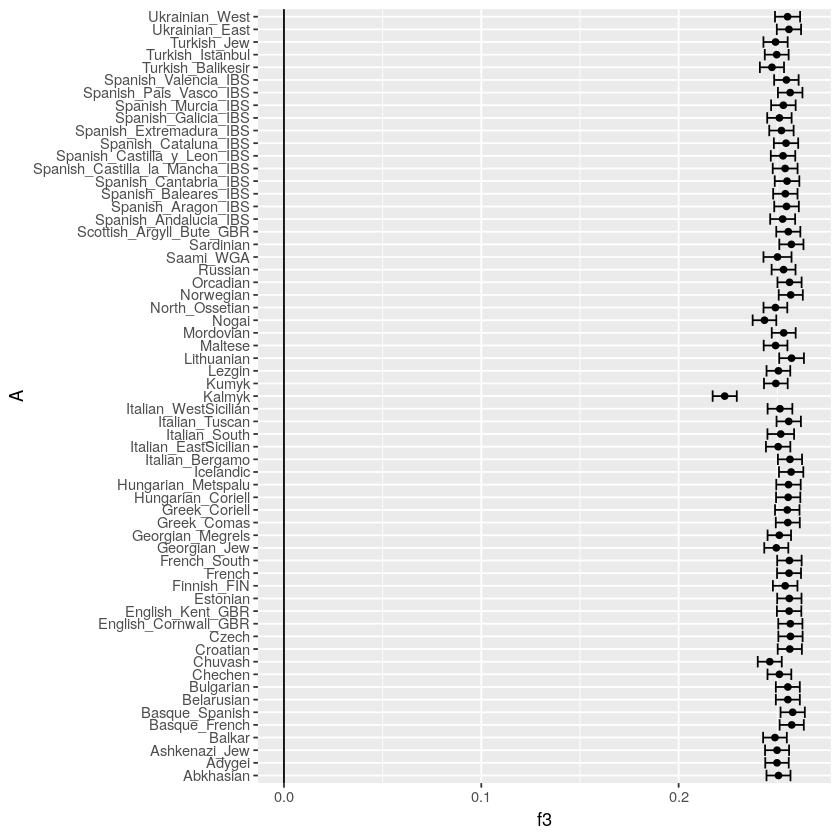

In [8]:
europe <- admixr::eigenstrat("data/europe/europe")
ind <- admixr::read_ind(europe)
pops <- unique(ind$label)
pops <- pops[!pops %in% c("Unknown", "MbutiPygmy")]

f3_res = f3(europe, A=pops, B="Unknown", C="MbutiPygmy")
viz_outgroup_f3(f3_res)

# 6. D-statistics
next, we can test for admixture in the past history of humans by lookin for an excess of ABBA or an excess of BABA sites in a 4-population tree.

For this purpose, we use the ancient dataset, which contains a subset of the Lazaridis-data with Chimpanzee, Oranguan, Neandertal, Denisovan and a small number of modern Human population samples.

To calculate D-stats is very similar to calculating $F_3$: instead of `admixr::f3` we use `admixr::d`:

**Task 3**: Use admixr (or if you really prefer, qp3Pop manually) to

 - load an eigenstrat object for the `ancient`-dataset
 - read all populations present in that data into memory using the `read_ind`-function
 - calculate all D-statistics of the form $D(MH_1, MH_2, AH, \text{Primate})$ 
 - create a figure visualizing your results


**Question 4**: Are any of the statistics significant? In what direction? (i.e. is there an excess of ABBA or BABA patterns, relative to what you would expect under a 4-population tree?). Is this consistent with what you might expect? 

In [9]:
ancient = eigenstrat("data/ancient/ancient")
ind = read_ind(ancient)
table(ind$label)
MH = c("French", "Han", "MbutiPygmy", "Papuan", "Yoruba")
AH = c("Ancient_Denisova", "Ancient_Neandertal")
P = c("Primate_Chimp", "Primate_Orangutan")
d_res = ancient %>% d(W=MH, X=MH, Y=AH, Z=P)
d_res = d(ancient, W=MH, X=MH, Y=AH, Z=P)


  Ancient_Denisova Ancient_Neandertal             French                Han 
                 1                  1                 25                 33 
        MbutiPygmy             Papuan      Primate_Chimp  Primate_Orangutan 
                10                 14                  1                  1 
            Yoruba 
                70 

Warning message in system(paste(cmd, "-p", par_file, ">", log_file)):
“error in running command”
BEGINNING OF OUTPUT FILE



END OF OUTPUT FILE





ERROR: Error: The output file we got from ADMIXTOOLS is truncated.
       Please examine the full output above and check for errors.


In [ ]:
d_res

In [ ]:
d_res %>% filter(X=="MbutiPygmy") %>%
mutate(sig=as.factor(abs(Zscore)>3)) %>%
ggplot(aes(x=W, y=D, ymin=D-3*stderr, ymax=D+3*stderr, color=sig)) + 
geom_point() + 
geom_errorbar() +
geom_hline(yintercept=0) +
facet_wrap(~Y*Z)

# 7. estimating admixture proportions
The final task in the F-statistics framework will be to calculate admixture proportions using the $F_4$-ratio. 

For this purpose, we will revisit the world-dataset that we used with the $F_3$-statistics already. It contains 12 populations throughout the globe. In the Admixture-$F_3$ exercise we found that the Uygurs may be modelled as a mixture of an East-Asian population and a Western Eurasian population. We would now like to estimate the contributions from each population
    ![f4r](F4.large.jpg)

**Task 4**: Use `admixr` (or if you really prefer, qpF4ratio manually) to

- load an eigenstrat object for the world-dataset
- read all populations present in that data into memory using the `read_ind`-function
- have a look at the help by typing `?f4ratio` and comparing it with the tree above
- set up some $F_4$-ratios with appropriate populations to estimate the admixture proportions of the `Uygurs`.
- justify why you are using which population in which position
- what is your estimated admixture proportion?

In [ ]:
world = eigenstrat('data/world/world')
pops = read_ind(world) %>% select(label) %>% unique
pops

In [ ]:
f4ratio(world, O = c('Yoruba'), X='Uygur', C=c('Sardinian', 'French'), A=c('Papuan','Surui'), B='Han' )